In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import glob
import os
import json
import torch
from torchvision import datasets, models, transforms
from PIL import Image

In [2]:
# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda


In [34]:
# loading the json files
# loading datasets
training_labels = []
for file in glob.glob('drive/MyDrive/Datasets/03-WheresWally/TrainingSet/*.json'):
    training_labels.append(json.loads(open(file).read()))

# removing data with not enought points to locate wally
labels_to_be_removed = []
for i in range(len(training_labels)):
    if len(training_labels[i]['shapes'][0]['points']) < 4:
        labels_to_be_removed.append(i)

print(f'removing {len(labels_to_be_removed)} labels')
training_labels_with_removed_data = []
for i in range(len(training_labels)):
  if i not in labels_to_be_removed:
    training_labels_with_removed_data.append(training_labels[i])


removing 7 labels


In [19]:
# loading images
training_images = []
for image in training_labels:
    im_path = 'drive/MyDrive/Datasets/03-WheresWally/TrainingSet/' + image['imagePath']
    training_images.append(Image.open(im_path))
    
test_images = []
for image in glob.glob('drive/MyDrive/Datasets/03-WheresWally/TestSet/*'):
    test_images.append(Image.open(image))

In [20]:
# creating a custom pytorch dataset
class WallyDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, transform=None):
        """
        Args:
            images (list):
            train (bool):
            label (list):
            transform (callable, optional):
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        self.size = len(self.images)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        item_im = self.images[idx]
        if self.transform:
            item_im = self.transform(item_im)
            item_im = item_im.unsqueeze(0)
        
        if self.labels:
            item_points = self.convert_points(self.labels[idx]['shapes'][0]['points'])
            return {"image":item_im, "points":item_points}
        return {"image": item_im}
    
    def convert_points(self, points):
        """
        As it is easier to predict a box with x,y, width and height instead of predicting each point that composes
        the wally image, it is profitable to convert those given points to a format where a box, instead of a polygon,
        is drawn on the image.
        Input:
            points (list): points that trace the wally image in a polygon shape
        Output:
            [x,y,w,h] (list): list of x, y, width and height of the box that locates Wally's image 
        """
        
        x_points = [x[0] for x in points ]
        y_points = [y[1] for y in points ]
        x,y = min(x_points), min(y_points)
        w = np.linalg.norm(x-max(x_points))
        h = np.linalg.norm(y-max(y_points))
        return [x,y,w,h]


In [35]:
# transform will convert the images into tensors and do the apropriate pre processing steps
# as a aditional processing step, data augmentation will be implemented in the transformation as well

# the data augmentation will only mess the image color aspect, since rotating it or flipping will 
# lose the given wally's coordinates points for training
train_transform = transforms.Compose([
    transforms.RandomGrayscale(),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5)),
])
train_dataset = WallyDataset(training_images, labels=training_labels_with_removed_data, transform=train_transform)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5)),
])
test_dataset = WallyDataset(test_images, transform=test_transform)

In [36]:
print(train_dataset.size)

113


In [23]:
# defining some visualization funcitons
def im_convert(tensor):
    """
        Converts a tensor to a pil image
    """
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1,2,0) # H, W, C
    image = image * np.array((0.5,0.5,0.5)) + (0.5,0.5,0.5) # range de -1 a 1
    image = image.clip(0,1) # range de 0 a 1
    
    return image

def image_plot(image, path_points = None):
    """
        Plot a image and a square in it if points are provided
    """
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis("off")
    if path_points is not None:
        p = draw_rect(path_points)
        if p is not None: ax.add_patch(p)
    plt.show()

def draw_rect(points, color='red'):
    """
        Returns a path given 4 points
        Used to draw the rectangles in images
    """
    if len(points) != 4:
        return None
    x,y,h,w = points
    return patches.Rectangle((x,y),h,w, linewidth=2, facecolor='none', edgecolor=color)

def iou_score(box1, box2):
  """
  Calculate the score of the predictions
  """
  box1_x, box1_y, box1_h, box1_w = box1
  box2_x, box2_y, box2_h, box2_w = box2

  xi1 = max(box1_x, box2_x)
  yi1 = max(box1_y, box2_y)
  xi2 = min(box1_x + box1_w, box2_x + box2_w)
  yi2 = min(box1_y + box1_h, box2_y + box2_h)
  inter_w = xi2 - xi1
  inter_h = yi2 - yi1
  intersection_area = max(inter_w, 0) * max(inter_h, 0)

  box1_area = box1_h * box1_w
  box2_area = box2_h * box2_w
  union_area =  box1_area + box2_area - intersection_area

  iou = intersection_area / union_area

  return iou

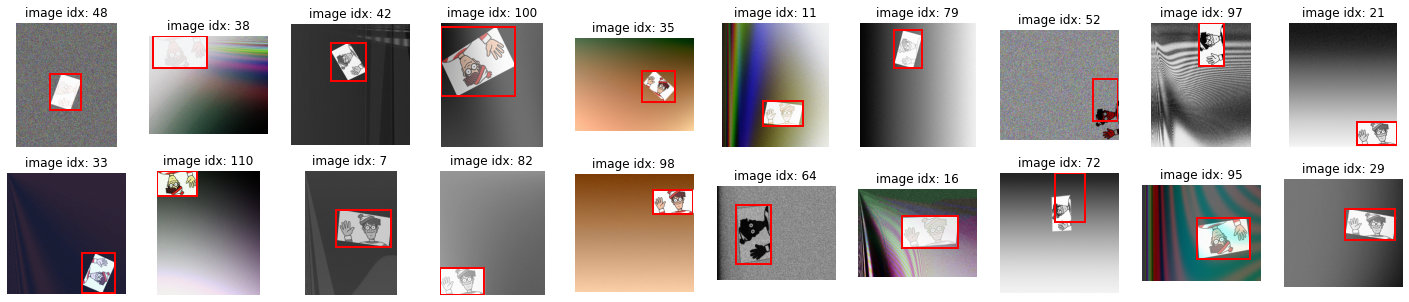

In [38]:
# taking a look into the dataset
fig = plt.figure(figsize=(25,5))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1)
    random_index = np.random.randint(0,train_dataset.size)
    plt.imshow(im_convert(train_dataset[random_index]['image']))
    p = draw_rect(train_dataset[random_index]['points'])
    if p is not None: ax.add_patch(p)
    plt.axis("off")
    plt.title(f"image idx: {random_index}")

### The model
In this task, I'll be performing a transfer learning using the pretrained model to locate Wally's image. The model's parameters will be frozen, so they won't be trained, with excession to the last layer, that will get a new output layer, in a way that it outputs the box that better wrap wally's image, using it's x, y, width and height. 

In [138]:
# loading vgg
model = models.vgg16(pretrained=True)
# freezing the features section parameters
for param in model.features.parameters():
  param.requires_grad_(False)

In [139]:
n_inputs = model.classifier[6].in_features
last_layer = torch.nn.Linear(n_inputs, 4)
model.classifier[6] = last_layer
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [140]:
# defining loss and optmizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.5 )

# for training and evaluation purposes
epochs = 100
running_loss_history = []
running_corrects_history = []

In [141]:
# training
for e in range(epochs):
  running_loss = 0.0
  running_correct = 0.0
  
  for i in range(train_dataset.size):
    input = train_dataset[i]['image'].to(device)
    points = train_dataset[i]['points']
    output = model(input)
    loss = criterion(output, torch.FloatTensor([points]).to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # eval
    running_loss += loss.item()
    running_correct += iou_score(points, output[0].cpu().detach().numpy())


  else:
    epoch_loss = running_loss/train_dataset.size
    running_loss_history.append(epoch_loss)

    epoch_correct = running_correct/train_dataset.size
    running_corrects_history.append(epoch_correct)

    
    print(f"{e+1}/{epochs}")
    print(f"\t loss: {epoch_loss}\t acc: {epoch_correct}")



1/100
	 loss: 126016.46849073561	 acc: 0.0001168124278417333
2/100
	 loss: 50832.08083647332	 acc: 0.09051032504659107
3/100
	 loss: 29493.108203989214	 acc: 0.1501441729466694
4/100
	 loss: 28251.789874861726	 acc: 0.1591958605452912
5/100
	 loss: 26587.70616055379	 acc: 0.18270457018352218
6/100
	 loss: 26204.189673499724	 acc: 0.1874133506352391
7/100
	 loss: 25574.00794213219	 acc: 0.18606635561203558
8/100
	 loss: 25765.687750622234	 acc: 0.1963232258707956
9/100
	 loss: 24831.96743207273	 acc: 0.1868734933082239
10/100
	 loss: 24339.90003197594	 acc: 0.21313056643495076
11/100
	 loss: 23490.68691233407	 acc: 0.2128878375608401
12/100
	 loss: 22916.831520283118	 acc: 0.21918544962674744
13/100
	 loss: 21944.13727400788	 acc: 0.23539307067969453
14/100
	 loss: 19876.781685348105	 acc: 0.24975240556479217
15/100
	 loss: 18158.192981821245	 acc: 0.2693081210958614
16/100
	 loss: 16373.904070018667	 acc: 0.27859861933877683
17/100
	 loss: 14991.717913872373	 acc: 0.2932077054871917
18

Text(0.5, 1.0, 'Loss Graphic')

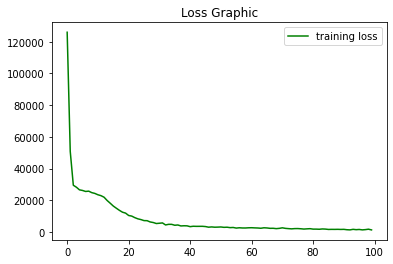

In [142]:
plt.plot(running_loss_history, 'g', label="training loss")
plt.legend()
plt.title("Loss Graphic")

Text(0.5, 1.0, 'Accuracy Graph')

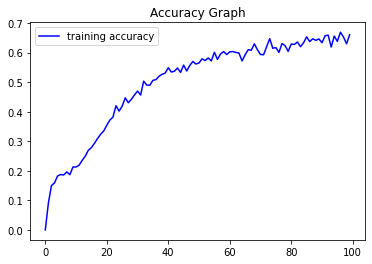

In [143]:
plt.plot(running_corrects_history, 'b', label="training accuracy")
plt.legend()
plt.title("Accuracy Graph")

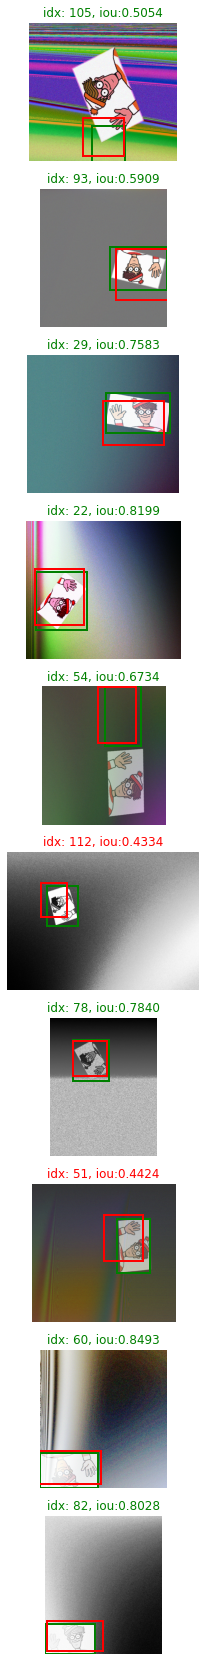

In [164]:
# taking a look into the prediction
# the given box is drawn in green, while the predicted box is drawn in red
fig = plt.figure(figsize=(6,30))
count = 0
for idx in range(0,10):
    count += 1
    random_index = np.random.randint(0,train_dataset.size)
    ax = fig.add_subplot(10, 1, count)
    plt.imshow(im_convert(train_dataset[random_index]['image']))
    p = draw_rect(train_dataset[random_index]['points'], color='green',)
    if p is not None: ax.add_patch(p)

    pred = model(train_dataset[random_index]['image'].to(device))
    pred = pred[0].cpu().detach().numpy()
    pred_p = draw_rect(pred)
    if pred_p is not None: ax.add_patch(pred_p)
    score = iou_score(train_dataset[random_index]['points'], pred)
    plt.axis("off")
    plt.title(f"idx: {random_index}, iou:{score:.4f}", color=("red" if score < 0.5 else "green"))

In [149]:
# running the trained model in unseen data
preds_test = []
for image in test_dataset:
  p = model(image['image'].to(device))
  preds_test.append(p[0].cpu().detach().numpy())
  

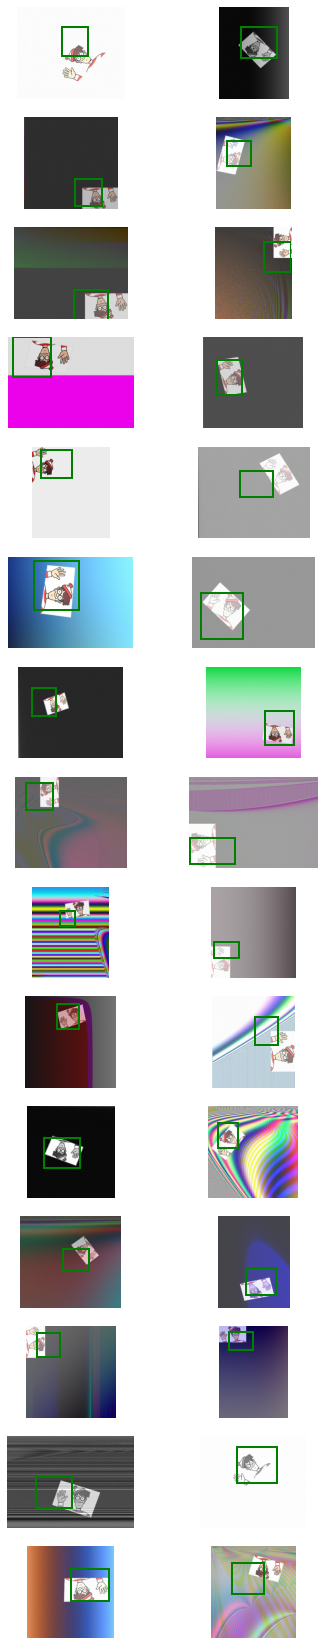

In [150]:
# taking a look into the prediction
fig = plt.figure(figsize=(6,30))
count = 0
for idx in range(0,30):
    count += 1
    ax = fig.add_subplot(15, 2, count)
    plt.imshow(im_convert(test_dataset[idx]['image']))
    p = draw_rect(preds_test[idx], color='green')
    if p is not None: ax.add_patch(p)

    plt.axis("off")